# Read Data From CSV

In [10]:
import plotly
import plotly.graph_objs as go
import plotly.express as px

from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from numpy.linalg import norm
from quaternion import Quaternion
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
import os
from os import walk
import madgwickahrs as mg
from quaternion import Quaternion


In [546]:
#функции калибровки
def find_offsets(mpu,counts = 80):
#     calibration_set = mpu.loc[:counts]
    calibration_set =mpu 
    n = float(len(calibration_set))
    summ = []
    offsets = []
    for i in calibration_set:
        summ.append(calibration_set[i].sum())
    for s in summ:
        offsets.append(s/n)
    return offsets

def find_headers(mpu):
    headers = []
    for i in mpu:
        headers.append(i)
    return headers

def calibration(mpu,dataset):
    
    headers = find_headers(mpu)
#     print(headers)
    
    off = find_offsets(mpu)
    calibrated = mpu.copy()
    #не калибровать ускорение для фильтра маджвика!
    calibrated[headers[0]] = mpu[headers[0]] - off[0]
#  calibrated[headers[1]] = mpu[headers[1]] - off[1]
    calibrated[headers[2]] = mpu[headers[2]] - off[2]
    
    calibrated[headers[3]] = mpu[headers[3]] - off[3]
    calibrated[headers[4]] = mpu[headers[4]] - off[4]
    calibrated[headers[5]] = mpu[headers[5]] - off[5]
    
    return calibrated


In [547]:
#функции для вывода графиков
def show_plots(mpu_t,mpu_b,title_t,title_b,accel=None):
    
    headers_t = find_headers(mpu_t)
    headers_b = find_headers(mpu_b)
    
    if accel == True:
        headers_t = headers_t[:3]
        headers_b = headers_b[:3]
        title_t += ' accel'
        title_b += ' accel'
    elif accel == None:
        headers_t = headers_t[:3]
        title_t +='accel'
        headers_b = headers_b[3:]
        title_b += ' gyro'
    else:
        headers_t = headers_t[3:]
        headers_b = headers_b[3:]
        title_t += ' gyro'
        title_b += ' gyro'
        


    fig = make_subplots(rows=1, cols=2, subplot_titles=(title_t,title_b))


    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[0]],name=headers_t[0]),1,1)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[1]],name=headers_t[1]),1,1)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[2]],name=headers_t[2]),1,1)

    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_b[headers_b[0]],name=headers_b[0]),1,2)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_b[headers_b[1]],name=headers_b[1]),1,2)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_b[headers_b[2]],name=headers_b[2]),1,2)


    fig.update_layout(legend_orientation="h",
                      legend=dict(x=.5, xanchor="center"),
                      hovermode="x",
                      margin=dict(l=0, r=0, t=40, b=0))
    fig.show()


def show_plot(mpu_t,title_t,accel=None):
    
    headers_t = find_headers(mpu_t)
    
    if accel == True:
        headers_t = headers_t[:3]
        title_t += ' accel'
    elif accel == None:
        headers_t = headers_t
    else:
        headers_t = headers_t[3:]
        title_t += ' gyro'
        


    fig = go.Figure() 
    fig.update_layout(title=title_t)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[0]],name=headers_t[0]))
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[1]],name=headers_t[1]))
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[2]],name=headers_t[2]))

    fig.show()


In [548]:
def read_csv_file(file_path):
    df = pd.read_csv(file_path,sep = ' ',header = None)
    df.columns = ["s1","bt_ax","bt_ay","bt_az","bt_gx","bt_gy","bt_gz",
                 "s2","bb_ax","bb_ay","bb_az","bb_gx","bb_gy","bb_gz",
                 "s3","lt_ax","lt_ay","lt_az","lt_gx","lt_gy","lt_gz",
                 "s4","lb_ax","lb_ay","lb_az","lb_gx","lb_gy","lb_gz",
                "s5","rt_ax","rt_ay","rt_az","rt_gx","rt_gy","rt_gz",
                 "s6","rb_ax","rb_ay","rb_az","rb_gx","rb_gy","rb_gz",
                 ]

    return df

In [549]:
#each  IMU for calibration
def parse_to_sensors(df):
    
    bt = df[["bt_ax","bt_ay","bt_az","bt_gx","bt_gy","bt_gz"]]
    bb = df[["bb_ax","bb_ay","bb_az","bb_gx","bb_gy","bb_gz"]]
    lt = df[["lt_ax","lt_ay","lt_az","lt_gx","lt_gy","lt_gz"]]
    lb = df[["lb_ax","lb_ay","lb_az","lb_gx","lb_gy","lb_gz"]]
    rt = df[["rt_ax","rt_ay","rt_az","rt_gx","rt_gy","rt_gz"]]
    rb = df[["rb_ax","rb_ay","rb_az","rb_gx","rb_gy","rb_gz"]]
    
    return bt,bb,lt,lb,rt,rb


# Filter outliers

In [550]:
def filter_outliers(df_local):
    
    outl = find_headers(df_local)
    df= df_local.copy()
    print(outl)
    for o in outl:
        median = df[o].median()
        std = df[o].std()
        df.loc[(df[o] - median).abs() > std,o]=np.nan
        df[o].fillna(median, inplace=True)
    return df

def find_outliers(df):
    
    bt,bb,lt,lb,rt,rb = parse_to_sensors(df)
    
    rb_outl = filter_outliers(rb)
    rt_outl =filter_outliers(rt)
    lb_outl = filter_outliers(lb)
    lt_outl = filter_outliers(lt)
    bb_outl = filter_outliers(bb)
    bt_outl = filter_outliers(bt)
    

    return bt_outl,bb_outl,lt_outl,lb_outl,rt_outl,rb_outl 


 Calibrate DF of each sensor

# Madgwick filter

In [618]:
def find_orientation(calibrated_mpu):
    
    headers = find_headers(calibrated_mpu)
        
    quaternions = []

    heading = mg.MadgwickAHRS(sampleperiod = 1/16,beta =0.5)
    for i,row in calibrated_mpu.iterrows():
        gyro_d  = []
        accel_d = []
        gyro_d.append(row[headers[3]])
        gyro_d.append(row[headers[5]])
        gyro_d.append(row[headers[4]])
        accel_d.append(row[headers[0]])
        accel_d.append(row[headers[1]])
        accel_d.append(row[headers[2]])

        heading.update_imu(gyro_d,accel_d)
        quaternions.append(heading.quaternion._get_q())

    # print(quaternions)
    pitch = []
    roll = []
    yaw = []
    for i in range(len(quaternions)):
        pitch.append(np.arcsin(2 * quaternions[i][1] * quaternions[i][2] + 2 * quaternions[i][0] * quaternions[i][3]))
        if np.abs(quaternions[i][1] * quaternions[i][2] + quaternions[i][3] * quaternions[i][0] - 0.5) < 1e-8:
            roll.append(0) 
            yaw.append(2 * np.arctan2(quaternions[i][1], quaternions[i][0]))
        elif np.abs(quaternions[i][1] * quaternions[i][2] + quaternions[i][3] * quaternions[i][0] + 0.5) < 1e-8:
            roll.append(-2 * np.arctan2(quaternions[i][1], quaternions[i][0]))
            yaw.append(0)
        else:
            roll.append(np.arctan2(2 * quaternions[i][0] * quaternions[i][1] - 2 * quaternions[i][2] *quaternions[i][3], 1 - 2 * quaternions[i][1] ** 2 - 2 *quaternions[i][3] ** 2))
            yaw.append(np.arctan2(2 * quaternions[i][0] * quaternions[i][2] - 2 * quaternions[i][1] * quaternions[i][3], 1 - 2 * quaternions[i][2] ** 2 - 2 * quaternions[i][3] ** 2))


    orientation_d = pd.DataFrame({'roll':np.rad2deg(roll),'pitch':np.rad2deg(pitch),'yaw':np.rad2deg(yaw)})
    return orientation_d

    

# Calibration data

In [619]:
def all_calibrate(calibration_set):


#     bt_outl,bb_outl,lt_outl,lb_outl,rt_outl,rb_outl =  find_outliers(calibration_set)
    
    bt_outl,bb_outl,lt_outl,lb_outl,rt_outl,rb_outl =  parse_to_sensors(calibration_set)
    bt_1,bb_1,lt_1,lb_1,rt_1,rb_1=parse_to_sensors(calibration_set)

    show_plot(rt_1,'Test rt rpy ',False)
    show_plot(rt_1,'Test rt rpy ',True)
    
    calibrated_bt = calibration(bt_outl,bt_1)
    calibrated_bb = calibration(bb_outl,bb_1)
    calibrated_lt = calibration(lt_outl,lt_1)
    calibrated_lb = calibration(lb_outl,lb_1)
    calibrated_rb = calibration(rb_outl,rb_1)
    calibrated_rt = calibration(rt_outl,rt_1)
   
     
#     show_plot(calibrated_rt,'Calibrated rt rpy ',False)
#     show_plot(calibrated_rt,'Calibrated rt rpy ',True)
    #show_plot(calibrated_rt,'calibrated test rt tpy ',False)

#     print(calibrated_lb)
    orientation_bt = find_orientation(calibrated_bt)
    orientation_bb = find_orientation(calibrated_bb)
    orientation_lt = find_orientation(calibrated_lt)
    orientation_lb = find_orientation(calibrated_lb)
    orientation_rt = find_orientation(calibrated_rt)
    orientation_rb = find_orientation(calibrated_rb)

    show_plot(orientation_rt,f'Orientation lt sensor')
    return   orientation_bt, orientation_bb, orientation_lt, orientation_lb, orientation_rt, orientation_rb
    


In [620]:
def preprocessing_dataset(dataset):
    df = dataset.drop(columns = "Unnamed: 0")
    df.columns = ["roll_bt","pitch_bt","yaw_bt",
                  "roll_bb","pitch_bb","yaw_bb",
                  "roll_lt","pitch_lt","yaw_lt",
                  "roll_lb","pitch_lb","yaw_lb",
                  "roll_rt","pitch_rt","yaw_rt",
                  "roll_rb","pitch_rb","yaw_rb"
                 ]
    return df


In [621]:
name = 'test'
filename = f"D:/Thesis/{name}/20_rt1_y.csv"

calibration_set = read_csv_file(f"D:/Thesis/calibration/600_calibration.csv")
print(filename) 

IMU_set = read_csv_file(filename)
IMU_set

bt_1,bb_1,lt_1,lb_1,rt_1,rb_1=parse_to_sensors(IMU_set)
bt_outl,bb_outl,lt_outl,lb_outl,rt_outl,rb_outl =  parse_to_sensors(calibration_set)

show_plot(rt_1,'Test rt rpy ',False)
#show_plot(rt_outl,'Test rt rpy ',True) 
calibrated_rt = calibration(bt_1,bt_outl)


show_plot(calibrated_rt,'Calbrated rt rpy ',False)
# show_plot(rt_outl,'Test rt rpy ',True)
    

orientation_rt_t = find_orientation(calibrated_rt)
show_plot(orientation_rt_t,f'Orientation lt sensor')



D:/Thesis/test/20_rt1_y.csv


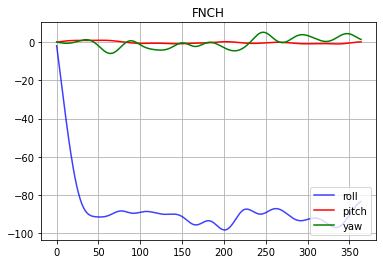

In [622]:
fnch = filter_angles(orientation_rt_t)
matplot_plot(fnch,'FNCH')

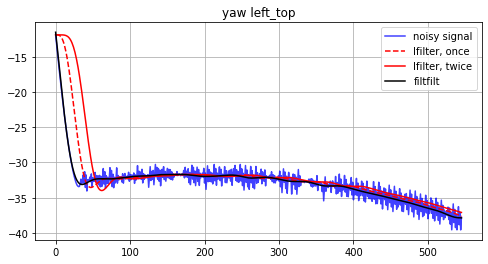

In [623]:
plt.figure(figsize=(8, 4))
plt.title(f"yaw left_top")
filtered_my_data=filter_scipy(my_data['yaw_lt'],True)


In [511]:
name = 'test'
сalibration_set= read_csv_file(f'calibration/30_calibration.csv')

сalibration_file = read_csv_file(f"D:/Thesis/test/30_rt_rpy.csv")
filenames = next(walk(f'D:/Thesis/{name}/'), (None, None, []))[2]  # [] if no file
filenames[0]
for i in range(len(filenames)):
    filename = f"D:/Thesis/{name}/{filenames[i]}"
    print(filename)
    IMU_set = read_csv_file(filename)
    orientation_bt, orientation_bb, orientation_lt, orientation_lb, orientation_rt, orientation_rb = all_calibrate(IMU_set)
    ready_dataset = pd.concat([orientation_bt, orientation_bb, orientation_lt, orientation_lb, orientation_rt, orientation_rb],axis = 1)    
    #     print(ready_dataset)
    ready_dataset.to_csv(f"D:\Thesis\dataset\lifting_orientation_{i}_0.csv", sep=",")


D:/Thesis/test/20_rt1_y.csv


D:/Thesis/test/30_rt_rpy.csv


In [344]:

# plt.figure
# plt.plot(orientation_lb_test.index, orientation_lb_test["roll_lb"], 'b', alpha=0.75)
# plt.plot(orientation_lb_test.index, frame['pitch'], 'r', orientation_lb_test.index,  orientation_lb_test["yaw_lb"], 'g')
# plt.legend(('roll', 'pitch', 'yaw'), loc='best')
# plt.grid(True)
# plt.show()


In [55]:
# orientation_lb_test.loc[:]

# Filter dataset

In [34]:
def find_headers_orient(mpu):
    headers = []
    for i in mpu:
        headers.append(i)
    return headers

In [35]:
def filter_scipy(dataset,my_angle=False):
    xn = dataset
    b, a = signal.butter(3, 0.05)
    zi = signal.lfilter_zi(b, a)
    z, _ = signal.lfilter(b, a, xn, zi=zi* xn[0])
    z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
    y = signal.filtfilt(b, a, xn)
    if my_angle == True: 
    # вывод работы ФНЧ
        plt.figure
        plt.plot(dataset.index, xn, 'b', alpha=0.75)
        plt.plot(dataset.index, z, 'r--', dataset.index, z2, 'r', dataset.index, y, 'k')
        plt.legend(('noisy signal', 'lfilter, once', 'lfilter, twice',
                'filtfilt'), loc='best')
        plt.grid(True)
        plt.show()
    
    return y

In [36]:
# xn = orientation_lb_test['yaw_lb']
# b, a = signal.butter(3, 0.05)
# zi = signal.lfilter_zi(b, a)
# z, _ = signal.lfilter(b, a, orientation_lb_test['yaw_lb'], zi=zi* orientation_lb_test['yaw_lb'][0])

In [37]:
# z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
# y = signal.filtfilt(b, a, xn)


In [38]:
def filter_angles(dataset_test):
    
    headers_orient  = find_headers_orient(dataset_test)
    filtered_roll =  filter_scipy(dataset_test[headers_orient[0]])
    filtered_pitch =  filter_scipy(dataset_test[headers_orient[1]]) 
    filtered_yaw =  filter_scipy(dataset_test[headers_orient[2]])
    
    filtered_roll_pd = pd.DataFrame(filtered_roll)
    filtered_pitch_pd = pd.DataFrame(filtered_pitch)
    filtered_yaw_pd = pd.DataFrame(filtered_yaw)
    frame = pd.concat([filtered_roll_pd,filtered_pitch_pd,filtered_yaw_pd],axis = 1)
#     if headers_orient[0] == 'roll_lt' or 'roll_rt':
#         frame.columns = ["roll",  "yaw","pitch"]
#     else:
    frame.columns = ["roll", "pitch", "yaw"]
#     frame = frame[['yaw',"roll"]]
    return frame


In [39]:

# filtered_roll_pd = pd.DataFrame(filtered_roll)
# filtered_pitch_pd = pd.DataFrame(filtered_pitch)
# filtered_yaw_pd = pd.DataFrame(filtered_yaw)
# frame = pd.concat([filtered_roll_pd,filtered_pitch_pd,filtered_yaw_pd],axis = 1)
# frame.columns = ["roll", "pitch", "yaw"]
# frame

In [40]:

def matplot_plot(frame,name_sensor_plot):
    plt.title(f"{name_sensor_plot}")
    plt.plot(frame.index, frame['roll'], 'b', alpha=0.75)
    plt.plot(frame.index, frame['pitch'], 'r')
    plt.plot(frame.index,  frame['yaw'], 'g')
#     plt.legend(('roll', 'yaw'), loc='lower right')
    plt.legend(('roll', 'pitch', 'yaw'), loc='lower right')
    plt.grid(True)




0


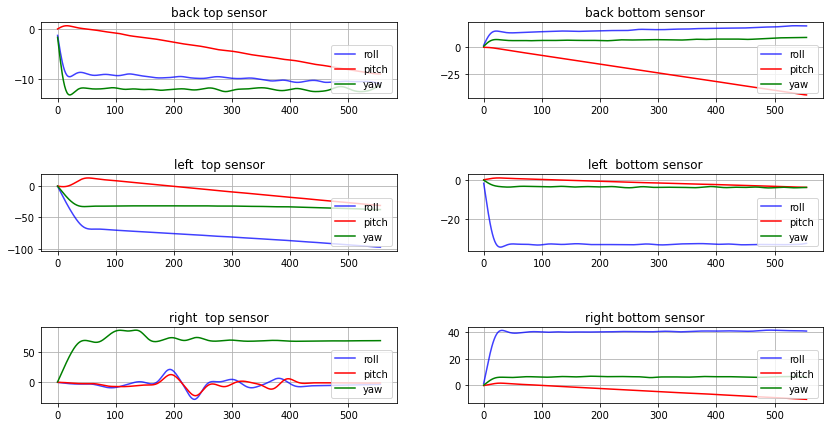

In [41]:
i = input()
test_plot = pd.read_csv(f'D:/Thesis/dataset/lifting_orientation_{i}_0.csv')


test_plot_1 = preprocessing_dataset(test_plot)


bt_h = ["roll_bt","pitch_bt","yaw_bt"]
bb_h = ["roll_bb","pitch_bb","yaw_bb"]
lt_h = [ "roll_lt","pitch_lt","yaw_lt"]
lb_h = ["roll_lb","pitch_lb","yaw_lb"]
rt_h =["roll_rt","pitch_rt","yaw_rt"]
rb_h = [ "roll_rb","pitch_rb","yaw_rb"]
                 
name_sensor_plot = 'lb_h'

orientation_bt_test= test_plot_1[bt_h]
orientation_bb_test= test_plot_1[bb_h]
orientation_lt_test= test_plot_1[lt_h]
orientation_lb_test= test_plot_1[lb_h]
orientation_rt_test= test_plot_1[rt_h]
orientation_rb_test= test_plot_1[rb_h]


frame_bt = filter_angles(orientation_bt_test)
frame_bb = filter_angles(orientation_bb_test)
frame_lt = filter_angles(orientation_lt_test)
frame_lb = filter_angles(orientation_lb_test)
frame_rt = filter_angles(orientation_rt_test)
frame_rb = filter_angles(orientation_rb_test)


# frame = frame.loc[15:]
plt.figure(figsize=(14, 7))
plt.subplots_adjust(hspace=1)



plt.subplot(3, 2, 1)
matplot_plot(frame_bt,'back top sensor')

plt.subplot(3, 2, 2)
matplot_plot(frame_bb,'back bottom sensor')


plt.subplot(3, 2,3)
matplot_plot(frame_lt,'left  top sensor')

plt.subplot(3, 2,4)
matplot_plot(frame_lb,'left  bottom sensor')


plt.subplot(3, 2, 5)
matplot_plot(frame_rt,'right  top sensor')


plt.subplot(3, 2, 6)
matplot_plot(frame_rb,'right bottom sensor')
plt.show()


In [42]:
test_plot = pd.read_csv(f'D:/Thesis/dataset/lifting_orientation_0_0.csv')
test_plot_1 = preprocessing_dataset(test_plot)
test_plot_1

features = ['roll_bt','roll_bb','yaw_lt','yaw_lb','yaw_rt','yaw_rb']
my_data = test_plot_1[features].loc[10:].reset_index(drop=True)
my_data



,roll_bt,roll_bb,yaw_lt,yaw_lb,yaw_rt,yaw_rb
0,-8.342853,13.587163,-11.890484,-2.078608,22.724189,3.567747
1,-9.483831,13.989120,-12.942284,-2.266356,24.695016,3.883566
2,-8.366360,13.752952,-13.971337,-2.501862,26.701151,4.184563
3,-9.624377,13.927770,-14.996056,-2.699496,28.693987,4.451020
4,-8.503290,13.402998,-16.009066,-2.902975,30.606492,4.753790
...,...,...,...,...,...,...
541,-10.014594,19.694966,-36.266231,-4.435736,69.117824,5.765006
542,-11.087339,21.798548,-38.836827,-3.464981,68.007503,7.735005
543,-11.014013,19.936194,-37.087793,-4.389845,69.457569,5.661815
544,-10.755837,21.972842,-39.567801,-3.768409,69.828933,7.671477


In [43]:
def create_dataset(test_plot):
   
    test_plot_1 = preprocessing_dataset(test_plot)
    test_plot_1

    features = ['roll_bt','roll_bb','yaw_lt','yaw_lb','yaw_rt','yaw_rb']
    my_data = test_plot_1[features].loc[10:].reset_index(drop=True)
    return my_data


for i in range(len(next(walk(f'D:/Thesis/dataset/'), (None, None, []))[2] )):
    test_plot = pd.read_csv(f'D:/Thesis/dataset/lifting_orientation_{i}_0.csv')
    dataset =  create_dataset(test_plot)
    dataset.to_csv(f"D:\Thesis\RNN\sample_{i}_0.csv", sep=",")

In [44]:
test_plot = pd.read_csv(f'D:/Thesis/RNN/sample_0_0.csv')
test_plot

,Unnamed: 0,roll_bt,roll_bb,yaw_lt,yaw_lb,yaw_rt,yaw_rb
0,0,-8.342853,13.587163,-11.890484,-2.078608,22.724189,3.567747
1,1,-9.483831,13.989120,-12.942284,-2.266356,24.695016,3.883566
2,2,-8.366360,13.752952,-13.971337,-2.501862,26.701151,4.184563
3,3,-9.624377,13.927770,-14.996056,-2.699496,28.693987,4.451020
4,4,-8.503290,13.402998,-16.009066,-2.902975,30.606492,4.753790
...,...,...,...,...,...,...,...
541,541,-10.014594,19.694966,-36.266231,-4.435736,69.117824,5.765006
542,542,-11.087339,21.798548,-38.836827,-3.464981,68.007503,7.735005
543,543,-11.014013,19.936194,-37.087793,-4.389845,69.457569,5.661815
544,544,-10.755837,21.972842,-39.567801,-3.768409,69.828933,7.671477


# Orientation only with gyro 

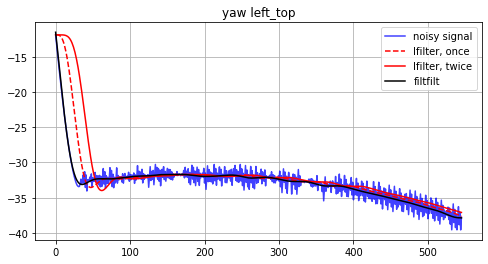

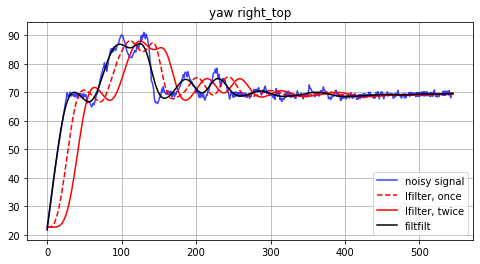

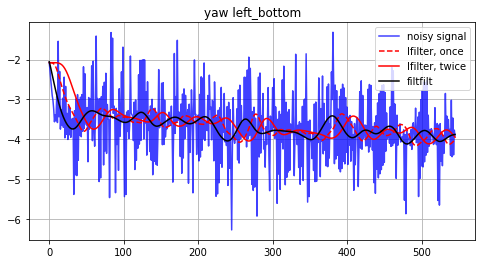

In [45]:
plt.figure(figsize=(8, 4))
plt.title(f"yaw left_top")
filtered_my_data=filter_scipy(my_data['yaw_lt'],True)


plt.figure(figsize=(8, 4))
plt.title(f"yaw right_top")
filtered_my_data=filter_scipy(my_data['yaw_rt'],True) 

plt.figure(figsize=(8, 4))
plt.title(f"yaw left_bottom")
filtered_my_data=filter_scipy(my_data['yaw_lb'],True) 

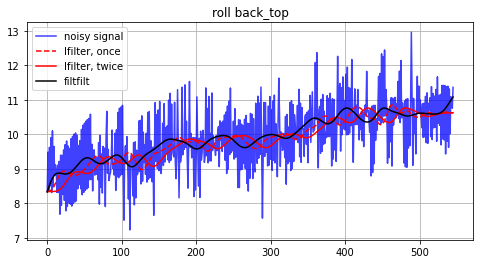

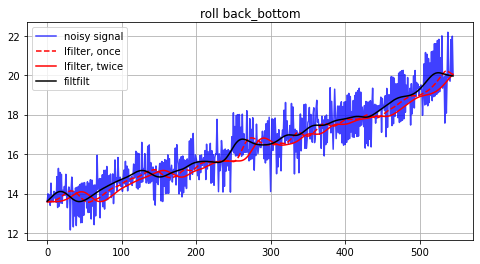

In [46]:
plt.figure(figsize=(8, 4))
plt.title(f"roll back_top")
filtered_my_data=filter_scipy(my_data['roll_bt']*-1,True) 
plt.figure(figsize=(8,4))
plt.title(f"roll back_bottom")
filtered_my_data=filter_scipy(my_data['roll_bb'],True) 


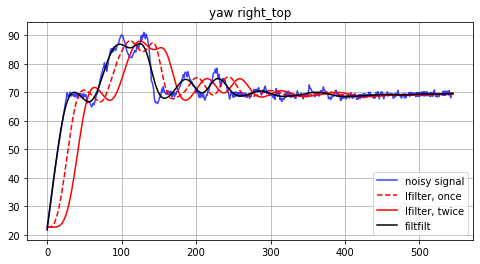

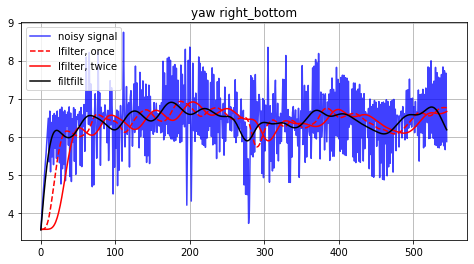

In [47]:
plt.figure(figsize=(8, 4))
plt.title(f"yaw right_top")
filtered_my_data=filter_scipy(my_data['yaw_rt'],True) 
plt.figure(figsize=(8, 4))
plt.title(f"yaw right_bottom")
filtered_my_data=filter_scipy(my_data['yaw_rb'],True) 

In [48]:


# pitch = np.zeros(len(calibrated_lb))
# yaw = np.zeros(len(calibrated_lb))
# roll = np.zeros(len(calibrated_lb))

# for i in range(len(calibrated_lb)-1):
#     delta_t = 0.06
    
#     pitch[i+1] = pitch[i] + calibrated_lb['lb_gy'][i]*delta_t
#     yaw[i+1] = yaw[i]+calibrated_lb['lb_gz'][i]*delta_t
#     roll[i+1] = roll[i]+calibrated_lb['lb_gx'][i]*delta_t
    

# orientation_d = pd.DataFrame({'roll':np.rad2deg(roll),'pitch':np.rad2deg(pitch),'yaw':np.rad2deg(yaw)})

# show_plot(orientation_d,'Orientation only with  gyro')

In [49]:
#(-0.02213089742574257, 0.01005698124752475, -0.013309934386138617)